In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from bresenham import bresenham
from queue import PriorityQueue
from planning_utils import a_star, heuristic
%matplotlib inline 
import sys
# ! pip install -I networkx==2.1
import pkg_resources
# pkg_resources.require("networkx==2.1")
import networkx as nx
print(nx.__version__)
plt.rcParams['figure.figsize'] = 14, 14

2.1


## create grid and generate vornoi graph

In [18]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    centers = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            centers.append([north - north_min, east - east_min])

    return grid, centers, int(north_min), int(east_min)

def generate_graph(grid, points):
    print(len(points))
    vornoi_graph = Voronoi(points)
    graph = nx.Graph()
    edges = []
    for v in vornoi_graph.ridge_vertices:
        p1 = vornoi_graph.vertices[v[0]]
        p2 = vornoi_graph.vertices[v[1]]
        
        # optimizing the path using bresenham method
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the graph
        if not hit:
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            dist = np.linalg.norm(np.array(p2) - np.array(p1))
            graph.add_edge(p1, p2, weight=dist)
            edges.append([p1,p2])
    return graph, edges
    

In [30]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
grid, centers, north_min, east_min = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
graph, edges = generate_graph(grid, centers)

3845


In [31]:
print('Found %5d edges' % len(edges))

Found  1419 edges


In [32]:
def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    branch[next_node] = (new_cost, current_node)
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

def heuristic(position, goal_position):
    return np.linalg.norm(np.array(position) - np.array(goal_position))

In [33]:
def closest_point(p,graph):
    min_dist = 1000000
    point = None
    for node in graph.nodes:
        dist = np.linalg.norm(np.array(node) - np.array(p))
        if dist < min_dist:
            point = node
            min_dist = dist
    return point

In [75]:
from udacidrone.frame_utils import global_to_local, local_to_global

start = (316, 445) 
goal = (60, 131)
grid_start= closest_point(start, graph)
grid_goal = closest_point(goal, graph)

global_home = np.array([-122.39745 ,  37.79248 ,   0.     ])
d= local_to_global((goal[0], goal[1], 0), global_home)
print(d)

local_goal = global_to_local(d, global_home)
grid_goal = (local_goal[0] - nmin, local_goal[1] - emin )
print(grid_goal)

60.76114000000001
131.76850000000002
[-122.39595777   37.79301314    0.        ]
(375.9999952353537, 576.0019442058401)


In [71]:
path,path_cost = a_star(graph, heuristic, grid_start, grid_goal) 
path_pairs = zip(path[:-1], path[1:])


# path2 = [(315.76114, 445.76846), (323.76114, 445.76846), (342.42783202225417, 459.1018114444672), (348.838057892751, 462.30692568579923), (351.67021033141174, 469.85933372769733), (352.1897110510204, 470.76846), (353.8380622130178, 474.6146127662722), (358.76114, 480.76846), (370.76114, 500.76846), (380.76114, 510.76846), (390.7611974999563, 520.7685174999563), (403.26110072914287, 528.2684559374982), (404.0944374999812, 530.76846), (407.79816473938746, 552.990723436202), (400.76114, 558.2684937499987), (385.761145000005, 565.768494999995), (377.4278066666667, 574.1018333333334), (376.76114, 576.7685), (315.9878836530261, 444.84158981614746)]
# path_pairs2 = zip(path2[:-1], path2[1:])

**********************
Failed to find a path!
**********************


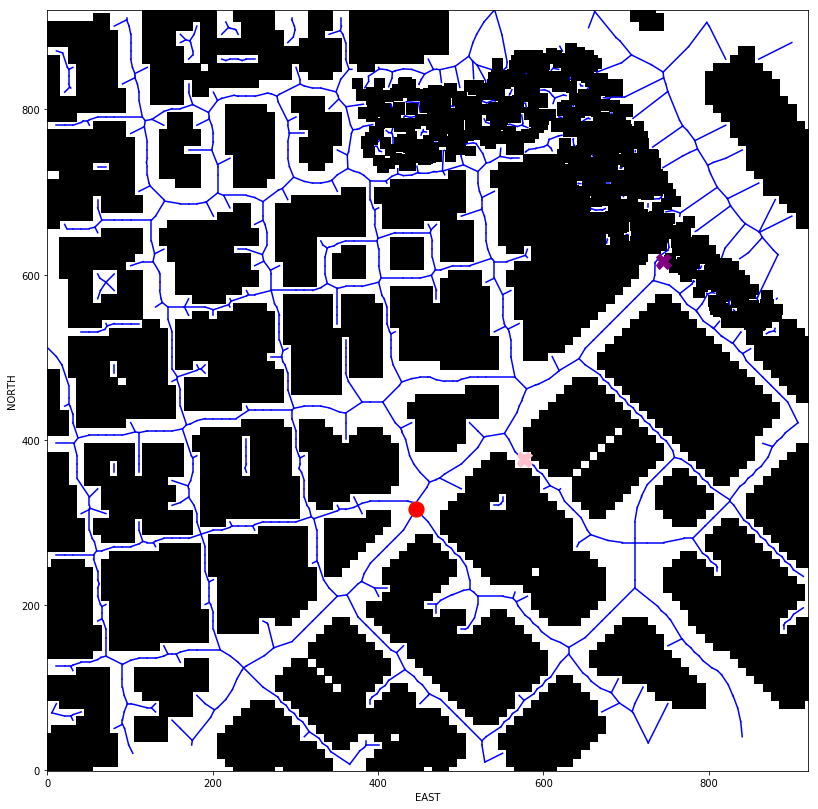

In [72]:
plt.imshow(grid, origin='lower', cmap='Greys') 
nmin =  north_min 
emin = east_min 

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.plot(grid_start[1], grid_start[0], marker='o', linewidth=5, markersize=15, c='orange')
plt.plot(grid_goal[1], grid_goal[0], marker='X', linewidth=5, markersize=15, c='purple')

a =(315.76114, 445.76846) 
b=(376.76114, 576.7685)
plt.plot(a[1], a[0], marker='o', linewidth=5, markersize=15, c='red')
plt.plot(b[1], b[0], marker='X', linewidth=5, markersize=15, c='pink')
for (n1, n2) in path_pairs:
    plt.plot([n1[1] , n2[1] ], [n1[0] , n2[0]], 'green', linewidth=5)


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()